In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import pickle
import datetime

In [24]:
year_list = [2015,2016,2017,2018,2019]
link_list = []
for year in year_list:
    url = f"https://www.boxofficemojo.com/year/{year}/?grossesOption=calendarGrosses"
    response = requests.get(url)
    status = response.status_code
    if status == 200:
        page = response.text
        soup = bs(page)
        table_html = soup.find("table")
        all_links = table_html.find_all('a')
        for link in all_links:
            if link.get("href")[0] == "/":
                link_list.append(link.get('href'))
        
    else:
        print(f"Received status code {status}")

In [43]:

clean_links = [link.split("?")[0] for link in link_list]
with open('clean_links.pkl', 'wb') as f:
    pickle.dump(clean_links, f)

In [86]:
headers = ['movie title', 'domestic total gross', 'international gross', 'worldwide gross', 'genres',
           'runtime (mins)', 'rating', 'release date', 'widest release', 'budget', 'distributor']

In [96]:
import re
def get_movie_value(soup, field_name):
    
    '''Grab a value from Box Office Mojo HTML
    
    Takes a string attribute of a movie on the page and returns the string in
    the next sibling object (the value for that attribute) or None if nothing is found.
    '''
    
    obj = soup.find(text=re.compile(field_name))
    
    if not obj: 
        return None
    
    # this works for most of the values
    next_element = obj.findNext()
    
    if next_element:
        return next_element.text 
    else:
        return None

get_movie_value and get_movie_boxoffice functions are taken from Metis Course materials

In [109]:
def get_movie_boxoffice(soup,ind):
    
    try:
        return soup.find(class_='mojo-performance-summary-table').find_all('span', class_= "money")[ind].text
    except:
        return None
        
    

In [89]:
test_links = [clean_links[1], clean_links[2], clean_links[3]]

'/release/rl2691925505/'

In [113]:
movie_dicts = []
for link in clean_links:
    movie_url = 'https://www.boxofficemojo.com'+link
    response = requests.get(movie_url)
    status = response.status_code
    if status == 200:
        page = response.text
        soup = bs(page)
        title_str = soup.find('title').text
        title = title_str.split('-')[0].strip()
        dom_gross = get_movie_boxoffice(soup,0)
        int_gross = get_movie_boxoffice(soup,1)
        ww_gross = get_movie_boxoffice(soup,2)
        genres = get_movie_value(soup,'Genres')
        genres = genres.replace("\n",'').replace('            ', ' ')
        runtime = get_movie_value(soup,'Running Time')
        rating = get_movie_value(soup,'MPAA')
        release_date = get_movie_value(soup,'Release Date')
        release_date = release_date.split('\n')[0]
        widest = get_movie_value(soup,'Widest Release')
        budget = get_movie_value(soup,'Budget')
        distributor = soup.find(text='Distributor').findNext().text.split("See full")[0]
        movie_dict = dict(zip(headers, [title,
                                dom_gross,
                                int_gross,
                                ww_gross,
                                genres,
                                runtime,
                                rating,
                                release_date,
                                widest,
                                budget,
                                distributor]))
        movie_dicts.append(movie_dict)
    else:
        print(link + ' error' + status)
print('Finished')

Finished


In [182]:
df = pd.DataFrame(movie_dicts)
df.sample(20)

NameError: name 'movie_dicts' is not defined

In [116]:
with open('BOmojo.pkl', 'wb') as f:
    pickle.dump(df, f)

In [231]:
with open('BOmojo.pkl', 'rb') as f:
    movies_df = pickle.load(f)

In [236]:
def action(genres):
    if 'action' in genres.lower():
        return 1
    else:
        return 0

In [4]:
def comedy(genres):
    if 'comedy' in genres.lower():
        return 1
    else:
        return 0

In [279]:
movies_df.head(10)

,movie title,domestic total gross,international gross,worldwide gross,genres,runtime (mins),rating,release date,widest release,budget,distributor,action,release_month
0,Jurassic World,652270625,1018130012,1.670401e+09,Action Adventure Sci-Fi,124.0,PG-13,"Jun 12, 2015",4291,150000000.0,Universal Pictures,1,jun
1,Star Wars: Episode VII,936662225,1131561399,2.068224e+09,Action Adventure Sci-Fi,138.0,PG-13,"Dec 18, 2015",4134,245000000.0,Walt Disney Studios Motion Pictures,1,dec
2,Avengers: Age of Ultron,459005868,943800000,1.402806e+09,Action Adventure Sci-Fi,141.0,PG-13,"May 1, 2015",4276,250000000.0,Walt Disney Studios Motion Pictures,1,may
3,Inside Out,356461711,501149463,8.576112e+08,Adventure Animation Comedy Drama Family Fantasy,95.0,PG,"Jun 19, 2015",4158,175000000.0,Walt Disney Studios Motion Pictures,0,jun
4,Furious 7,353007020,1162040651,1.515048e+09,Action Crime Thriller,137.0,PG-13,"Apr 3, 2015",4022,190000000.0,Universal Pictures,1,apr
5,American Sniper,350126372,197300000,5.474264e+08,Action Biography Drama War,133.0,R,"Dec 25, 2014 (Jan 16, 2015)",3885,58800000.0,Warner Bros.,1,dec
6,Minions,336045770,823352627,1.159398e+09,Adventure Animation Comedy Crime Family Sci-Fi,91.0,PG,"Jul 10, 2015",4311,74000000.0,Universal Pictures,0,jul
7,The Hunger Games: Mockingjay,281723902,376620235,6.583441e+08,Action Adventure Sci-Fi Thriller,137.0,PG-13,"Nov 20, 2015",4175,160000000.0,Lionsgate,1,nov
8,The Martian,228433663,401728227,6.301619e+08,Adventure Drama Sci-Fi,144.0,PG-13,"Oct 2, 2015",3854,108000000.0,Twentieth Century Fox,0,oct
9,Cinderella,201151353,341200000,5.423514e+08,Adventure Drama Family Fantasy Romance,105.0,PG,"Mar 13, 2015",3848,95000000.0,Walt Disney Studios Motion Pictures,0,mar


In [238]:
movies_df['action'] = movies_df['genres'].apply(action)
movies_df.head()

,movie title,domestic total gross,international gross,worldwide gross,genres,runtime (mins),rating,release date,widest release,budget,distributor,action
0,Jurassic World,"$652,270,625","$1,018,130,012","$1,670,400,637",Action Adventure Sci-Fi,2 hr 4 min,PG-13,"Jun 12, 2015","4,291 theaters","$150,000,000",Universal Pictures,1
1,Star Wars: Episode VII,"$936,662,225","$1,131,561,399","$2,068,223,624",Action Adventure Sci-Fi,2 hr 18 min,PG-13,"Dec 18, 2015","4,134 theaters","$245,000,000",Walt Disney Studios Motion Pictures,1
2,Avengers: Age of Ultron,"$459,005,868","$943,800,000","$1,402,805,868",Action Adventure Sci-Fi,2 hr 21 min,PG-13,"May 1, 2015","4,276 theaters","$250,000,000",Walt Disney Studios Motion Pictures,1
3,Inside Out,"$356,461,711","$501,149,463","$857,611,174",Adventure Animation Comedy Drama Family Fantasy,1 hr 35 min,PG,"Jun 19, 2015","4,158 theaters","$175,000,000",Walt Disney Studios Motion Pictures,0
4,Furious 7,"$353,007,020","$1,162,040,651","$1,515,047,671",Action Crime Thriller,2 hr 17 min,PG-13,"Apr 3, 2015","4,022 theaters","$190,000,000",Universal Pictures,1


In [239]:
def money_to_int(string):
    if string == None:
        return None
    else:
        return int(string.replace(',','').replace("$",""))

money_to_int function is modified from a version in Metis course materials

In [240]:
movies_df["domestic total gross"] = movies_df["domestic total gross"].apply(money_to_int)
movies_df["international gross"] = movies_df["international gross"].apply(money_to_int)
movies_df["worldwide gross"] = movies_df["worldwide gross"].apply(money_to_int)

In [241]:
movies_df['budget'] = movies_df["budget"].apply(money_to_int)

In [242]:
def widest_release(strng):
    s1 = strng.replace(',','')
    s2 = s1.split(' ')[0]
    return int(s2)

In [243]:
movies_df['widest release'] = movies_df['widest release'].apply(widest_release)
movies_df.head()

,movie title,domestic total gross,international gross,worldwide gross,genres,runtime (mins),rating,release date,widest release,budget,distributor,action
0,Jurassic World,652270625,1018130012,1.670401e+09,Action Adventure Sci-Fi,2 hr 4 min,PG-13,"Jun 12, 2015",4291,150000000.0,Universal Pictures,1
1,Star Wars: Episode VII,936662225,1131561399,2.068224e+09,Action Adventure Sci-Fi,2 hr 18 min,PG-13,"Dec 18, 2015",4134,245000000.0,Walt Disney Studios Motion Pictures,1
2,Avengers: Age of Ultron,459005868,943800000,1.402806e+09,Action Adventure Sci-Fi,2 hr 21 min,PG-13,"May 1, 2015",4276,250000000.0,Walt Disney Studios Motion Pictures,1
3,Inside Out,356461711,501149463,8.576112e+08,Adventure Animation Comedy Drama Family Fantasy,1 hr 35 min,PG,"Jun 19, 2015",4158,175000000.0,Walt Disney Studios Motion Pictures,0
4,Furious 7,353007020,1162040651,1.515048e+09,Action Crime Thriller,2 hr 17 min,PG-13,"Apr 3, 2015",4022,190000000.0,Universal Pictures,1


In [244]:
with open('BOmojo1.pkl', 'wb') as f:
    pickle.dump(movies_df, f)

In [245]:
with open('BOmojo1.pkl', 'rb') as f:
    movies_df = pickle.load(f)

In [246]:
def get_month(release_date):
    return release_date[0:3].lower()

In [247]:
movies_df['release_month'] = movies_df['release date'].apply(get_month)
movies_df['release_month'].value_counts()

dec    140
nov    123
oct     84
aug     84
mar     78
sep     78
jun     75
apr     75
jul     75
feb     71
may     63
jan     54
Name: release_month, dtype: int64

In [248]:
def runtime_conv(runtimestring):
    try:
        runtime = runtimestring.split()
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

In [249]:
movies_df['runtime (mins)'].isna().sum()

1

In [250]:
movies_df['runtime (mins)'] = movies_df['runtime (mins)'].apply(runtime_conv)
movies_df.head()

,movie title,domestic total gross,international gross,worldwide gross,genres,runtime (mins),rating,release date,widest release,budget,distributor,action,release_month
0,Jurassic World,652270625,1018130012,1.670401e+09,Action Adventure Sci-Fi,124.0,PG-13,"Jun 12, 2015",4291,150000000.0,Universal Pictures,1,jun
1,Star Wars: Episode VII,936662225,1131561399,2.068224e+09,Action Adventure Sci-Fi,138.0,PG-13,"Dec 18, 2015",4134,245000000.0,Walt Disney Studios Motion Pictures,1,dec
2,Avengers: Age of Ultron,459005868,943800000,1.402806e+09,Action Adventure Sci-Fi,141.0,PG-13,"May 1, 2015",4276,250000000.0,Walt Disney Studios Motion Pictures,1,may
3,Inside Out,356461711,501149463,8.576112e+08,Adventure Animation Comedy Drama Family Fantasy,95.0,PG,"Jun 19, 2015",4158,175000000.0,Walt Disney Studios Motion Pictures,0,jun
4,Furious 7,353007020,1162040651,1.515048e+09,Action Crime Thriller,137.0,PG-13,"Apr 3, 2015",4022,190000000.0,Universal Pictures,1,apr


In [251]:
movies_df1 = pd.concat([movies_df, pd.get_dummies(movies_df['rating'],drop_first=False)],axis = 1)
movies_df1.head()

,movie title,domestic total gross,international gross,worldwide gross,genres,runtime (mins),rating,release date,widest release,budget,distributor,action,release_month,G,Not Rated,PG,PG-13,R
0,Jurassic World,652270625,1018130012,1.670401e+09,Action Adventure Sci-Fi,124.0,PG-13,"Jun 12, 2015",4291,150000000.0,Universal Pictures,1,jun,0,0,0,1,0
1,Star Wars: Episode VII,936662225,1131561399,2.068224e+09,Action Adventure Sci-Fi,138.0,PG-13,"Dec 18, 2015",4134,245000000.0,Walt Disney Studios Motion Pictures,1,dec,0,0,0,1,0
2,Avengers: Age of Ultron,459005868,943800000,1.402806e+09,Action Adventure Sci-Fi,141.0,PG-13,"May 1, 2015",4276,250000000.0,Walt Disney Studios Motion Pictures,1,may,0,0,0,1,0
3,Inside Out,356461711,501149463,8.576112e+08,Adventure Animation Comedy Drama Family Fantasy,95.0,PG,"Jun 19, 2015",4158,175000000.0,Walt Disney Studios Motion Pictures,0,jun,0,0,1,0,0
4,Furious 7,353007020,1162040651,1.515048e+09,Action Crime Thriller,137.0,PG-13,"Apr 3, 2015",4022,190000000.0,Universal Pictures,1,apr,0,0,0,1,0


In [181]:
movies_df1 = movies_df1.drop(columns=['Not Rated'])

NameError: name 'movies_df1' is not defined

In [253]:
d_list = movies_df1['distributor'].value_counts()
d_list

Warner Bros.             116
Universal Pictures        91
Twentieth Century Fox     80
Lionsgate                 79
Paramount Pictures        68
                        ... 
Novus                      1
Zee TV                     1
Oscilloscope               1
The H Collective           1
GKIDS                      1
Name: distributor, Length: 87, dtype: int64

In [254]:
other_ds = list(d_list[d_list <= 40].index)

In [255]:
movies_df1['distributor'] = movies_df1['distributor'].replace(other_ds, 'other')
movies_df1['distributor'].value_counts()

other                                  441
Warner Bros.                           116
Universal Pictures                      91
Twentieth Century Fox                   80
Lionsgate                               79
Paramount Pictures                      68
Walt Disney Studios Motion Pictures     64
Sony Pictures Entertainment (SPE)       61
Name: distributor, dtype: int64

In [257]:
movies_df2 = pd.concat([movies_df1, pd.get_dummies(movies_df1['distributor'],drop_first=True)],axis = 1)

0    699
1    301
Name: action, dtype: int64

In [259]:
movies_df2['worldwide gross'].fillna(movies_df2['domestic total gross'] + movies_df2['international gross'],inplace = True)

In [260]:
movies_df2['runtime (mins)'].fillna(value=movies_df2['runtime (mins)'].mean(),inplace=True)

In [261]:
movies_df2['budget'].fillna(value=movies_df2['budget'].median(),inplace=True)

In [7]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

/Applications/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [264]:
movies_df2['release_month'].value_counts()

dec    140
nov    123
oct     84
aug     84
mar     78
sep     78
jun     75
apr     75
jul     75
feb     71
may     63
jan     54
Name: release_month, dtype: int64

We see that many of our variables, including all of the continuous variables, are statistically significant predictors of Worldwide Gross Box Office.  Longer runtime, higher budget, and wider releases are all positively correlated with Worlwide Gross, meaning that increasing any of those variables predicts an increase in Box Office.  Some of the dummy variables for Distributor and Rating are not statistically significant.

The default distributor (the one without a dummy variable) is Lions Gate, and with, the exception of Paramount, the coefficient for each of the other distributors' dummy variable is positive, meaning that films from those distributors predict higher box office than Lion's Gate.  The highest coeffcient is for Universal pictures, meaning that Universal Pictures films, while holding all other variables equal, predict higher box office than any other studio

All coefficients for ratings are negative, meaning the default rating, G, is associated with the highest box office.  This results may not be generalizable, as a small number of G-rated films are in the dataset, and they may be outliers compared to other G Rated films.  It may make sense to add an interaction variable between G-rated movies and Disney studios.

In [127]:
mae = sum(abs(movie_model.predict(X1) - y))/len(y)
print(mae)

109387880.91816792


To assess the precision of the model, I have chosen Mean Absolute Error, which tells us the avreage difference between predicted Box Office, and actual Box Office.  The MAE value of $108,941,600 tells us the the model is some way off being useful and that there is more work to be done

In [217]:
with open('BOmojo2.pkl', 'wb') as f:
    pickle.dump(movies_df2, f)

In [184]:
with open('BOmojo2.pkl', 'rb') as f:
    movies_df2 = pickle.load(f)

In [266]:
movies_df2.head()

,movie title,domestic total gross,international gross,worldwide gross,genres,runtime (mins),rating,release date,widest release,budget,...,PG,PG-13,R,Paramount Pictures,Sony Pictures Entertainment (SPE),Twentieth Century Fox,Universal Pictures,Walt Disney Studios Motion Pictures,Warner Bros.,other
0,Jurassic World,652270625,1018130012,1.670401e+09,Action Adventure Sci-Fi,124.0,PG-13,"Jun 12, 2015",4291,150000000.0,...,0,1,0,0,0,0,1,0,0,0
1,Star Wars: Episode VII,936662225,1131561399,2.068224e+09,Action Adventure Sci-Fi,138.0,PG-13,"Dec 18, 2015",4134,245000000.0,...,0,1,0,0,0,0,0,1,0,0
2,Avengers: Age of Ultron,459005868,943800000,1.402806e+09,Action Adventure Sci-Fi,141.0,PG-13,"May 1, 2015",4276,250000000.0,...,0,1,0,0,0,0,0,1,0,0
3,Inside Out,356461711,501149463,8.576112e+08,Adventure Animation Comedy Drama Family Fantasy,95.0,PG,"Jun 19, 2015",4158,175000000.0,...,1,0,0,0,0,0,0,1,0,0
4,Furious 7,353007020,1162040651,1.515048e+09,Action Crime Thriller,137.0,PG-13,"Apr 3, 2015",4022,190000000.0,...,0,1,0,0,0,0,1,0,0,0


In [267]:
season_dict = {'jun':"summer",
              'jul':"summer",
              'aug':"summer",
              'sep':"fall",
              'oct':'fall',
              'nov':'fall',
              'dec':'winter',
              'jan':'winter',
              'feb':'winter',
              'mar':'spring',
              'apr':'spring',
              'may':'spring'}
movies_df2['season'] = movies_df2['release_month'].map(season_dict)
movies_df2['season'].value_counts()

fall      285
winter    265
summer    234
spring    216
Name: season, dtype: int64

In [271]:
movies_df3 = pd.concat([movies_df2, pd.get_dummies(movies_df2['season'],drop_first=True)],axis = 1)
movies_df3.head()

,movie title,domestic total gross,international gross,worldwide gross,genres,runtime (mins),rating,release date,widest release,budget,...,Sony Pictures Entertainment (SPE),Twentieth Century Fox,Universal Pictures,Walt Disney Studios Motion Pictures,Warner Bros.,other,season,spring,summer,winter
0,Jurassic World,652270625,1018130012,1.670401e+09,Action Adventure Sci-Fi,124.0,PG-13,"Jun 12, 2015",4291,150000000.0,...,0,0,1,0,0,0,summer,0,1,0
1,Star Wars: Episode VII,936662225,1131561399,2.068224e+09,Action Adventure Sci-Fi,138.0,PG-13,"Dec 18, 2015",4134,245000000.0,...,0,0,0,1,0,0,winter,0,0,1
2,Avengers: Age of Ultron,459005868,943800000,1.402806e+09,Action Adventure Sci-Fi,141.0,PG-13,"May 1, 2015",4276,250000000.0,...,0,0,0,1,0,0,spring,1,0,0
3,Inside Out,356461711,501149463,8.576112e+08,Adventure Animation Comedy Drama Family Fantasy,95.0,PG,"Jun 19, 2015",4158,175000000.0,...,0,0,0,1,0,0,summer,0,1,0
4,Furious 7,353007020,1162040651,1.515048e+09,Action Crime Thriller,137.0,PG-13,"Apr 3, 2015",4022,190000000.0,...,0,0,1,0,0,0,spring,1,0,0


In [277]:
with open('BOmojo3.pkl', 'wb') as f:
    pickle.dump(movies_df3, f)

In [142]:
with open('BOmojo3.pkl', 'rb') as f:
    movies_df3 = pickle.load(f)

In [143]:
movies_df3['comedy'] = movies_df3['genres'].apply(comedy)
movies_df3['budget^2'] = movies_df3['budget'] ** 2

In [144]:
movies_df3['disneyG'] = movies_df3['G'] * movies_df3['Walt Disney Studios Motion Pictures']

In [145]:
X = movies_df3.drop(columns=['domestic total gross',
                     'international gross',
                     'worldwide gross',
                     'genres', 'Warner Bros.', 'Twentieth Century Fox',
                     'rating', 'Sony Pictures Entertainment (SPE)', 'Paramount Pictures', 'other',
                     'release date', 'movie title', 'widest release','release_month','season','G', 'R',
                     'distributor'])
y = movies_df3['worldwide gross']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=20)

In [146]:
X.isnull().sum()

runtime (mins)                         0
budget                                 0
action                                 0
PG                                     0
PG-13                                  0
Universal Pictures                     0
Walt Disney Studios Motion Pictures    0
spring                                 0
summer                                 0
winter                                 0
comedy                                 0
budget^2                               0
disneyG                                0
dtype: int64

In [147]:
X = movies_df3.drop(columns=['domestic total gross',
                     'international gross',
                     'worldwide gross',
                     'genres',
                     'rating',
                     'release date', 'movie title', 'widest release','release_month','season',
                     'distributor'])
y = movies_df3['worldwide gross']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=20)

In [148]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

In [149]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)

In [150]:
alphas = 10**np.linspace(-2,8,200)
lasso_model = LassoCV(alphas = alphas, cv=5)
lasso_model.fit(X_tr, y_train)
r_squared_train = lasso_model.score(X_tr, y_train)
alpha = lasso_model.alpha_
print(alpha)
print(r_squared_train)

1382622.1737646593
0.5637874981328124


In [151]:
lasso = Lasso(alpha = alpha)
lasso.fit(X_tr, y_train)
train_r_squared = lasso.score(X_tr, y_train)
test_r_squared = lasso.score(X_te, y_test)
print(train_r_squared)
print(test_r_squared)
print(list(zip(X_train.columns, lasso.coef_)))

0.5637874981328124
0.6969870472464622
[('runtime (mins)', 39319004.91518213), ('budget', 19331182.719663758), ('action', 16825932.32716003), ('G', -0.0), ('PG', 22735062.187836166), ('PG-13', 21015703.607715204), ('R', -0.0), ('Paramount Pictures', -5443989.449683834), ('Sony Pictures Entertainment (SPE)', 16997223.733883027), ('Twentieth Century Fox', 10697354.35868998), ('Universal Pictures', 30042240.68699674), ('Walt Disney Studios Motion Pictures', 67070851.4700829), ('Warner Bros.', 20397099.52461284), ('other', -23289581.103136726), ('spring', -8887962.88045937), ('summer', 0.0), ('winter', -544329.9316776677), ('comedy', 6983249.484512456), ('budget^2', 117116157.00585741), ('disneyG', -444490.7077242735)]


In [152]:
movies_df3['comedy-runtime'] = movies_df3['runtime (mins)'] * movies_df3['comedy']
movies_df3['action-runtime'] = movies_df3['runtime (mins)'] * movies_df3['action']

In [164]:
X = movies_df3.drop(columns=['domestic total gross',
                     'international gross',
                     'worldwide gross','spring', 'PG', 'PG-13',
                     'genres', 'Warner Bros.', 'Twentieth Century Fox', 'summer', 'winter', 'disneyG',
                     'rating', 'Sony Pictures Entertainment (SPE)', 'Paramount Pictures', 'other',
                     'release date', 'movie title', 'widest release','release_month','season','G', 'R',
                     'distributor'])
y = movies_df3['worldwide gross']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=20)

After running a Lasso Regression, several variables are dropped from the model, as they have 0 for coefficients at the level of alpha that minimizes model variance -- these variables are not included in the new X dataframe

In [165]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)

In [166]:
alphas = 10**np.linspace(-2,8,200)
lasso_model = LassoCV(alphas = alphas, cv=5)
lasso_model.fit(X_tr, y_train)
r_squared_train = lasso_model.score(X_tr, y_train)
alpha = lasso_model.alpha_
print(alpha)
print(r_squared_train)

615098.5788580504
0.535903721653715


In [167]:
lasso = Lasso(alpha = alpha)
lasso.fit(X_tr, y_train)
train_r_squared = lasso.score(X_tr, y_train)
test_r_squared = lasso.score(X_te, y_test)
print(train_r_squared)
print(test_r_squared)
print(list(zip(X_train.columns, lasso.coef_)))

0.535903721653715
0.7058160859132971
[('runtime (mins)', 33820364.137138516), ('budget', 62502833.618077576), ('action', -20191724.016733274), ('Universal Pictures', 33898144.74054506), ('Walt Disney Studios Motion Pictures', 69807308.2568627), ('comedy', 45945968.01737282), ('budget^2', 87026541.9756474), ('comedy-runtime', -30435923.049878303), ('action-runtime', 46077369.26081194)]


The finalized Lasso Model performed better on the test data than on the training data, which would suggest that the model isn't overfit.  The overall R^2 value for the model is still quite low though 

In [176]:
lasso = Lasso(alpha = alpha)
std.fit(X)
Xf = std.transform(X)
lasso.fit(Xf, y)
final_r_squared = lasso.score(Xf, y)
print(final_r_squared)

print(list(zip(X.columns, lasso.coef_)))

0.5714351571074052
[('runtime (mins)', 29351259.255240157), ('budget', 63651992.610552125), ('action', -24068069.531370185), ('Universal Pictures', 36084421.00389889), ('Walt Disney Studios Motion Pictures', 72276255.25228652), ('comedy', 53467143.70535015), ('budget^2', 93761732.2174354), ('comedy-runtime', -39388815.5426089), ('action-runtime', 45355300.36482229)]


With the model finalized, we run it on training and testing data together to get our final coefficients

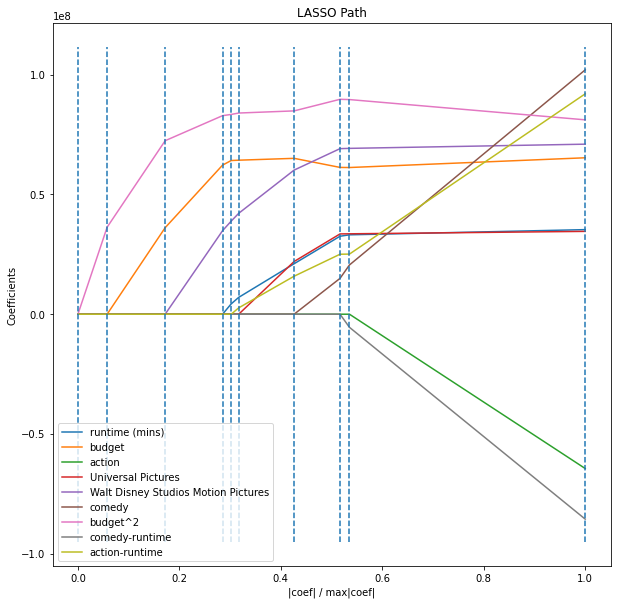

In [180]:
from sklearn.linear_model import lars_path
import matplotlib.pyplot as plt

alphas = 10**np.linspace(-2,8,200)

alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.savefig('lasso_path1.png')
plt.show()


Lasso Path code is taken from Metis Exercises

In [171]:
MAE = sum(abs(lasso.predict(X_te) - y_test))/len(y_test)
print(MAE)

95724302.91295788


The cell above is the Mean Absolute Error that the model achieved on the reserved testing set of data

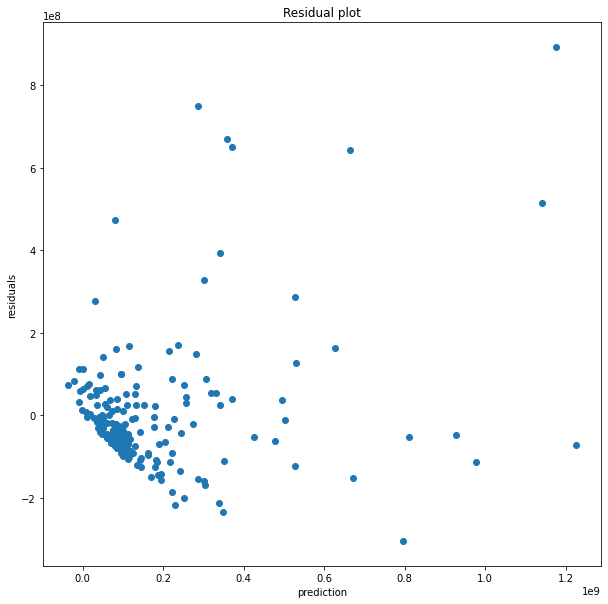

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
pred = lasso.predict(X_te)
res = y_test - pred
plt.scatter(pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")
plt.savefig('residuals.png')


In [177]:
overall_unscaled = 29351259 / X['runtime (mins)'].std()
comedy_unscaled = (-39388815 / X_train['comedy-runtime'].std()) + overall_unscaled
action_unscaled = (45355300 / X_train['action-runtime'].std()) + overall_unscaled
print(overall_unscaled)
print(comedy_unscaled)
print(action_unscaled)

1637976.1487284245
879826.8244403265
2463203.395852353


The purpose of the above is to find the marginal change in predicted revenue for an increase of one minute in runtime.  Since the features were standardized, the coefficent represents the change in box office for an increase of one standard deviation in each feature.  first we unscale the coefficients by dividing them by the standard deviation of each feature.  Since comedy and action movie predictions will also incporporate the overall runtime feature, we must also add the overall unscaled runtime feature to the genre-specific one to find the overall change in prediction from a one minute increase in runtime